In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.io import read_image
import torchvision
import os.path
import glob
import re

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
# class FruitImageDataset(torch.utils.data.Dataset):
#     def __init__(self, base_path, transform=None, target_transform=None):
#         self.images = glob.glob(os.path.join(base_path) + "/**/*")
#         self.transform = transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         img_path = self.images[idx]
#         image = read_image(img_path)
#         label = img_path.split("/")[-2]
        
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)

#         return image, label


In [4]:
base_path = "../data"

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.ImageFolder(os.path.join(base_path, "train"), transform=transform)
testset = datasets.ImageFolder(os.path.join(base_path, "test"), transform=transform)

classes = sorted(os.listdir(os.path.join(base_path, "train")))

In [5]:
classes

['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

In [6]:
batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=8)


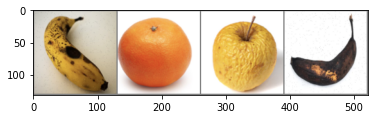

rottenbanana freshoranges rottenapples rottenbanana


In [7]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [8]:
labels

tensor([4, 2, 3, 4])

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 120, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(120, 16, 5)
        # 13456
        self.fc1 = nn.Linear(13456, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
torch.cuda.is_available(), device

(True, device(type='cuda', index=0))

In [12]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


/home/mark/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Finished Training


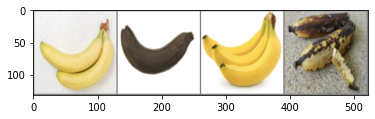

GroundTruth:  freshbanana rottenbanana freshbanana rottenbanana


In [21]:
dataiter = iter(testloader)
data = dataiter.next()
images, labels = data[0].to(device), data[1].to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [20]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(predicted))))

Predicted:  rottenbanana freshoranges freshbanana freshapples


In [14]:
errors = []
succeeded = 0
for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        errors1 = [
                {"predicted": predicted[j], "label": labels[j] }
                for j in range(len(labels)) if labels[j] != predicted[j]
        ]
        errors += errors1
        succeeded += len(labels) - len(errors1)
        

In [15]:
len(errors) / succeeded

0.06902356902356903

In [17]:
torch.save(net, "fruit.pth")